In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import sys
sys.path.append('../')

import math
from typing import Any, Dict, List, Optional

import rasterio
import contextily
import geopandas
import haversine as hs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from tqdm.notebook import tqdm

from huhuha.settings import RAW_DATA_DIR, DATA_DIR
from huhuha.centered_tiles import get_otm_center_tile
from huhuha.utils import get_elevation, random_float

tqdm.pandas()
sns.set_theme(style='whitegrid')

## Wczytanie zbioru danych

## Zapis pliku

## Wycentrowane tile

poniewaz w pierwotnej wersji tile byly pobierane w sposob nie wycentrowany oraz udalo nam sie dotrzec do nowego zbioru danych, postanowilismy troche zmodyfikować kod do fetchowania danych.

In [2]:
from PIL import Image


def plot_img(img, cmap='gray', title: Optional[str] = None, figsize=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    ax.imshow(img, cmap=cmap)
    ax.axis('off')
    if title is not None:
        ax.set_title(title)
        
def try_download_tile(
    _index: int,
    _id: None,
    lat: float, 
    lon: float, 
    zoom: int = None,
    folder: str = None,
) -> Optional[str]:
    
    if _id is None or np.isnan(_id):
        _id = f's{_index}'
    else:
        _id = str(int(_id))
        # _id = f's{_index}'
        
    print(f'_index: {_index}')
    
    if zoom:
        zoom = [zoom]
    else:
        zoom = [12, 13, 14, 15]
        
        
    for z in zoom:
        try:
            _ct = get_otm_center_tile(lat, lon, zoom=z, source='opentopomap')
            _ca = get_otm_center_tile(lat, lon, zoom=z, source='arcgis')
            
            im_ct = Image.fromarray(_ct)
            im_ca = Image.fromarray(_ca)
            
            ca_folder_path = f'{folder}/arcgis/{z}' 
            ct_folder_path = f'{folder}/opentopomap/{z}'
            
            Path.mkdir(Path(ca_folder_path), parents=True, exist_ok=True)
            Path.mkdir(Path(ct_folder_path), parents=True, exist_ok=True)
            
            im_ca.save(f'{ca_folder_path}/{_id}.png')
            im_ct.save(f'{ct_folder_path}/{_id}.png')
            
        except Exception as e:
            print(e)
            return 'None'

In [99]:
new_gdf = geopandas.read_file(DATA_DIR / 'avalanches-dataset.geojson')

In [100]:
df = pd.DataFrame(new_gdf.drop(columns='geometry'))

In [101]:
df.reset_index(inplace=True)

In [102]:
df_with_id = df[~df.id.isna()].astype({"id": int})
df_with_id = df_with_id.astype({"id": str})

In [103]:
df_without_id = df[df.id.isna()].astype({"id": str})
df_without_id['id'] = df_without_id['index'].apply(lambda x: f's{x}')

In [104]:
df = pd.concat([df_with_id, df_without_id])

In [38]:
df.progress_apply(
    lambda row: try_download_tile(
        _index=row['index'],
        _id=row.id, 
        lat=row.latitude, 
        lon=row.longitude, 
        folder=f'{DATA_DIR}/center_tiles/avalanches'
    ), 
    axis=1)

  0%|          | 0/7293 [00:00<?, ?it/s]

_index: 0
_index: 1
_index: 2
_index: 3
_index: 4
_index: 5
_index: 6
_index: 7
_index: 8
_index: 9
_index: 10
_index: 11
_index: 12
_index: 13
_index: 14
_index: 15
_index: 16
_index: 17
_index: 18
_index: 19
_index: 20
_index: 21
_index: 22
_index: 23
_index: 24
_index: 25
_index: 26
_index: 27
_index: 28
_index: 29
HTTPSConnectionPool(host='a.tile.opentopomap.org', port=443): Max retries exceeded with url: /12/2119/1478.png (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x14f8e6430>: Failed to establish a new connection: [Errno 61] Connection refused'))
_index: 30
HTTPSConnectionPool(host='b.tile.opentopomap.org', port=443): Max retries exceeded with url: /12/2118/1472.png (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x14f8e6940>: Failed to establish a new connection: [Errno 61] Connection refused'))
_index: 31
HTTPSConnectionPool(host='c.tile.opentopomap.org', port=443): Max retries exceeded with url: /12/2117/1473.png (

KeyboardInterrupt: 

In [105]:
del df['index']

In [106]:
df.to_csv(DATA_DIR / 'avalanches-dataset.csv', index=False)

In [107]:
df.head()

,id,date,updated,massif,sommet,description,orientation,latitude,longitude,tile_filename_zoom_16,Avalanche,elevations
0,1642072642225,1.641942e+12,1.642074e+12,aiguilles d arves,Aiguille de l'Epaisseur,"b""Apres s'etre decale trop sur la gauche par r...",E,45.130920,6.357383,openstreat_map_z_16_x_33925_y_23541.png,1,3136.0
1,1642001062328,1.641942e+12,1.642013e+12,None,None,b'Descente du Pcheu au Mont Joly. \r\nDeclench...,E,45.825902,6.693000,openstreat_map_z_16_x_33986_y_23360.png,1,2497.0
2,1642005733893,1.641856e+12,1.642006e+12,Haute Maurienne,Pointe de Vallonbrun,"b""Petite avalanche partie spontanement, probab...",SE,45.317667,6.937318,openstreat_map_z_16_x_34030_y_23492.png,1,2609.0
3,1641931532871,1.641856e+12,1.641932e+12,Belledonne,pointe du sciallet,"b""Declenchement de la plaque par 1 skieur. \r\...",E,45.212236,6.013909,openstreat_map_z_16_x_33862_y_23520.png,1,2280.0
4,1641918131562,1.641856e+12,1.641919e+12,Mont Thabor,Roche de la Pelle,"b""Avalanche spontanee partie tres probablement...",NE,45.136030,6.551387,openstreat_map_z_16_x_33960_y_23539.png,1,2829.0


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7293 entries, 0 to 7292
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3297 non-null   float64
 1   date                   3297 non-null   float64
 2   updated                3297 non-null   float64
 3   massif                 3213 non-null   object 
 4   sommet                 2856 non-null   object 
 5   description            2471 non-null   object 
 6   orientation            3297 non-null   object 
 7   latitude               7293 non-null   float64
 8   longitude              7293 non-null   float64
 9   tile_filename_zoom_16  7293 non-null   object 
 10  Avalanche              7293 non-null   int64  
 11  elevations             7293 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 683.8+ KB


<AxesSubplot:title={'center':'Avalanches count'}>

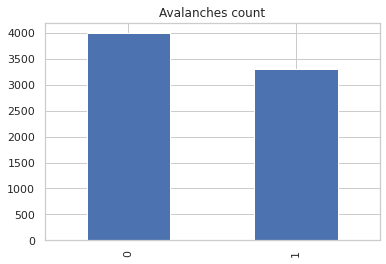

In [96]:
df['Avalanche'].value_counts().plot(kind='bar', title='Avalanches count')